# Mask R-CNN - Train on Astro Objects


Based on example of training Mask R-CNN on astronomical images.

In [25]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [26]:
# check that we have the devices we expect available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2226181455627534800, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7946286335905889990
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3141030323001678642
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15596303156
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15219625047261540044
 physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:58:00.0, compute capability: 7.0"]

## Dataset

In [27]:
from astropy.io import fits
from astropy.visualization.lupton_rgb import make_lupton_rgb
from astropy.table import Table
from matplotlib.image import imsave
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import random
import os.path

def crops(fnames, xrange, yrange):
    return [fits.open(f)[0].data[xrange[0]:xrange[1], yrange[0]:yrange[1]] for f in fnames]

class AstroObjectDataset(utils.Dataset):

    def load_hst_images(self, classtype='object',
                        cropsize=256, datadir='../../../images/',
                        fieldglob='*', cropglob='crops',
                        training=True, train_frac=0.8):
        datatable = Table.read(os.path.join(datadir,'mastersex.fits'))
        datatable.convert_bytestring_to_unicode()
        # Add classes
        if classtype == 'object':
            self.add_class("astroobject", 1, "object")
            self.nclass = 1
            datatable['object_class'] = 1
            classcolumn = 'object_class'
        elif classtype == 'mag':
            self.add_class("astroobject", 1, "faint")
            self.add_class("astroobject", 2, "medium")
            self.add_class("astroobject", 3, "bright")
            self.nclass = 3
            classcolumn = 'mag_class'
        elif classtype == 'colour':
            self.add_class("astroobject", 1, "blue")
            self.add_class("astroobject", 2, "red")
            self.nclass = 2
            classcolumn = 'colour_class'
        elif classtype == 'conc':
            self.add_class("astroobject", 1, "lowconc")
            self.add_class("astroobject", 2, "highconc")
            self.nclass = 2
            classcolumn = 'conc_class'
        elif classtype == 'colourconc':
            # example of combining to create a new set of classes
            datatable['colourconc_class'] = 0
            c = 0
            for i, colour in enumerate(['blue', 'red']):
                for j, conc in enumerate(['lowconc', 'highconc']):
                    c += 1
                    select = ((datatable['colour_class'] == i+1) &
                              (datatable['conc_class'] == j+1))
                    datatable['colourconc_class'][select] = c
                    self.add_class("astroobject", c, "{}_{}".format(colour, conc))
            self.nclass = c
            classcolumn = 'colourconc_class'

        datatable = datatable.to_pandas().set_index(['field', 'NUMBER'])
        self.objclass = datatable[classcolumn]
        
        # Add images
        imageglob = os.path.join(datadir, '{}/{}/crop*npy'.format(fieldglob, cropglob))
        images = glob(imageglob)
        random.seed(12345)
        random.shuffle(images)
        print('Total number of images:', len(images))
        if training:
            start = 0
            stop = int(train_frac * len(images))
        else:
            start = int(train_frac * len(images))
            stop = len(images)
        count = 0
        for k in range(start, stop):
            count += 1
            path = images[k]
            field = path.split('/')[-3]
            self.add_image("astroobject", image_id=k, path=path,
                           field=field,
                           width=cropsize, height=cropsize)
        print('Number of images used:', count)
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        img = np.load(info['path'])
        return img

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        seg = np.load(info['path'].replace('/crop_', '/mask_'))
        segids = list(set(seg.ravel()) - set([0]))
        nobj = len(segids)
        mask = np.zeros(seg.shape + (nobj,), np.bool)
        class_ids = np.zeros(nobj, dtype=np.int32)
        for i in range(nobj):
            mask[:,:,i] = seg == segids[i]
            idi = self.objclass.loc[info['field'], segids[i]]
            class_ids[i] = idi
        return mask, class_ids

In [28]:
classtype = 'colourconc'

# Training dataset
dataset_train = AstroObjectDataset()
dataset_train.load_hst_images(classtype, training=True)
dataset_train.prepare()

# Validation dataset
dataset_val = AstroObjectDataset()
dataset_val.load_hst_images(classtype, training=False)
dataset_val.prepare()

Total number of images: 9834
Number of images used: 7867
Total number of images: 9834
Number of images used: 1967


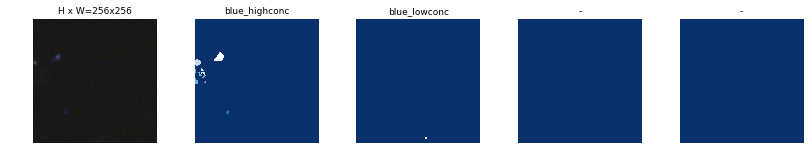

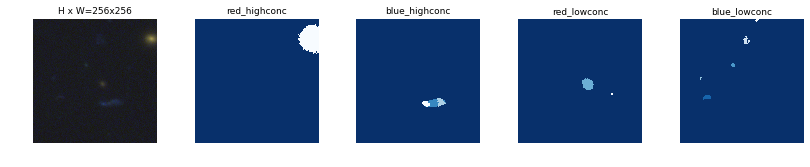

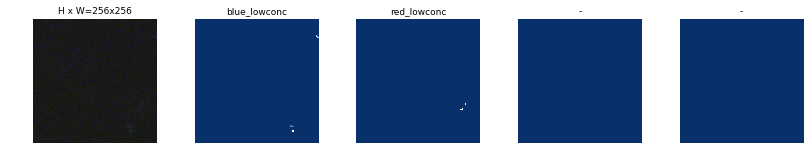

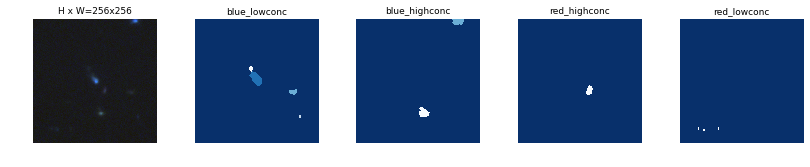

In [29]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Configurations

In [30]:
class AstroObjectsConfig(Config):
    """Configuration for training on the astroobjects dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "astroobjects"

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + dataset_train.nclass  # background + 1 object

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 64

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50
    
config = AstroObjectsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Helper functions

In [113]:
def get_history(model):
    eventfiles = sorted(glob(model.log_dir + '/events*'))
    history = {}
    for f in eventfiles:
        for e in tf.train.summary_iterator(f):
            for v in e.summary.value:
                if v.tag in history:
                    history[v.tag].append(v.simple_value)
                else:
                    history[v.tag] = [v.simple_value]
    return history

In [149]:
def histplot(history):
    hist = pd.DataFrame(history)
    n = len(hist.columns)//2
    fig, axarr = plt.subplots(n, 1, sharex=True,
                                   figsize=(10, 5*n))
    k = 0
    for c in hist.columns:
        if 'val' not in c:
            hist.plot(y=[c, 'val_'+c], ax=axarr[k])
            axarr[k].set_xlabel('epoch')
            axarr[k].set_ylabel(c)
            axarr[k].legend(loc='upper right')
            k += 1
    plt.tight_layout()

## Create Model

In [31]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [32]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [33]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=50, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /gpfs01/home/ppzsb1/astobjdet/Mask_RCNN/logs/astroobjects20190412T1223/mask_rcnn_astroobjects_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

300/300 [==============================] - 71s 236ms/step - loss: 1.4384 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.4991 - mrcnn_class_loss: 0.3080 - mrcnn_bbox_loss: 0.2574 - mrcnn_mask_loss: 0.3351 - val_loss: 2.6180 - val_rpn_class_loss: 0.0571 - val_rpn_bbox_loss: 1.0544 - val_mrcnn_class_loss: 0.5825 - val_mrcnn_bbox_loss: 0.5359 - val_mrcnn_mask_loss: 0.3881
Epoch 20/50
300/300 [==============================] - 77s 256ms/step - loss: 1.4042 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.4944 - mrcnn_class_loss: 0.3033 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.3371 - val_loss: 3.5704 - val_rpn_class_loss: 0.0761 - val_rpn_bbox_loss: 1.7282 - val_mrcnn_class_loss: 0.6831 - val_mrcnn_bbox_loss: 0.5841 - val_mrcnn_mask_loss: 0.4989
Epoch 21/50
300/300 [==============================] - 70s 235ms/step - loss: 1.5155 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5949 - mrcnn_class_loss: 0.3146 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.3291 - val_loss: 2.5382 - val_rpn_class_loss

Epoch 41/50
300/300 [==============================] - 82s 275ms/step - loss: 1.4254 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.5090 - mrcnn_class_loss: 0.3183 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.3173 - val_loss: 2.9191 - val_rpn_class_loss: 0.0810 - val_rpn_bbox_loss: 1.1858 - val_mrcnn_class_loss: 0.7798 - val_mrcnn_bbox_loss: 0.5021 - val_mrcnn_mask_loss: 0.3704
Epoch 42/50
300/300 [==============================] - 83s 276ms/step - loss: 1.4308 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.3323 - val_loss: 2.2157 - val_rpn_class_loss: 0.0278 - val_rpn_bbox_loss: 0.8489 - val_mrcnn_class_loss: 0.4196 - val_mrcnn_bbox_loss: 0.5224 - val_mrcnn_mask_loss: 0.3970
Epoch 43/50
300/300 [==============================] - 82s 274ms/step - loss: 1.5399 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.5426 - mrcnn_class_loss: 0.3129 - mrcnn_bbox_loss: 0.2943 - mrcnn_mask_loss: 0.3504 - val_loss: 2.4504 - val_rp

In [117]:
history_heads = get_history(model)

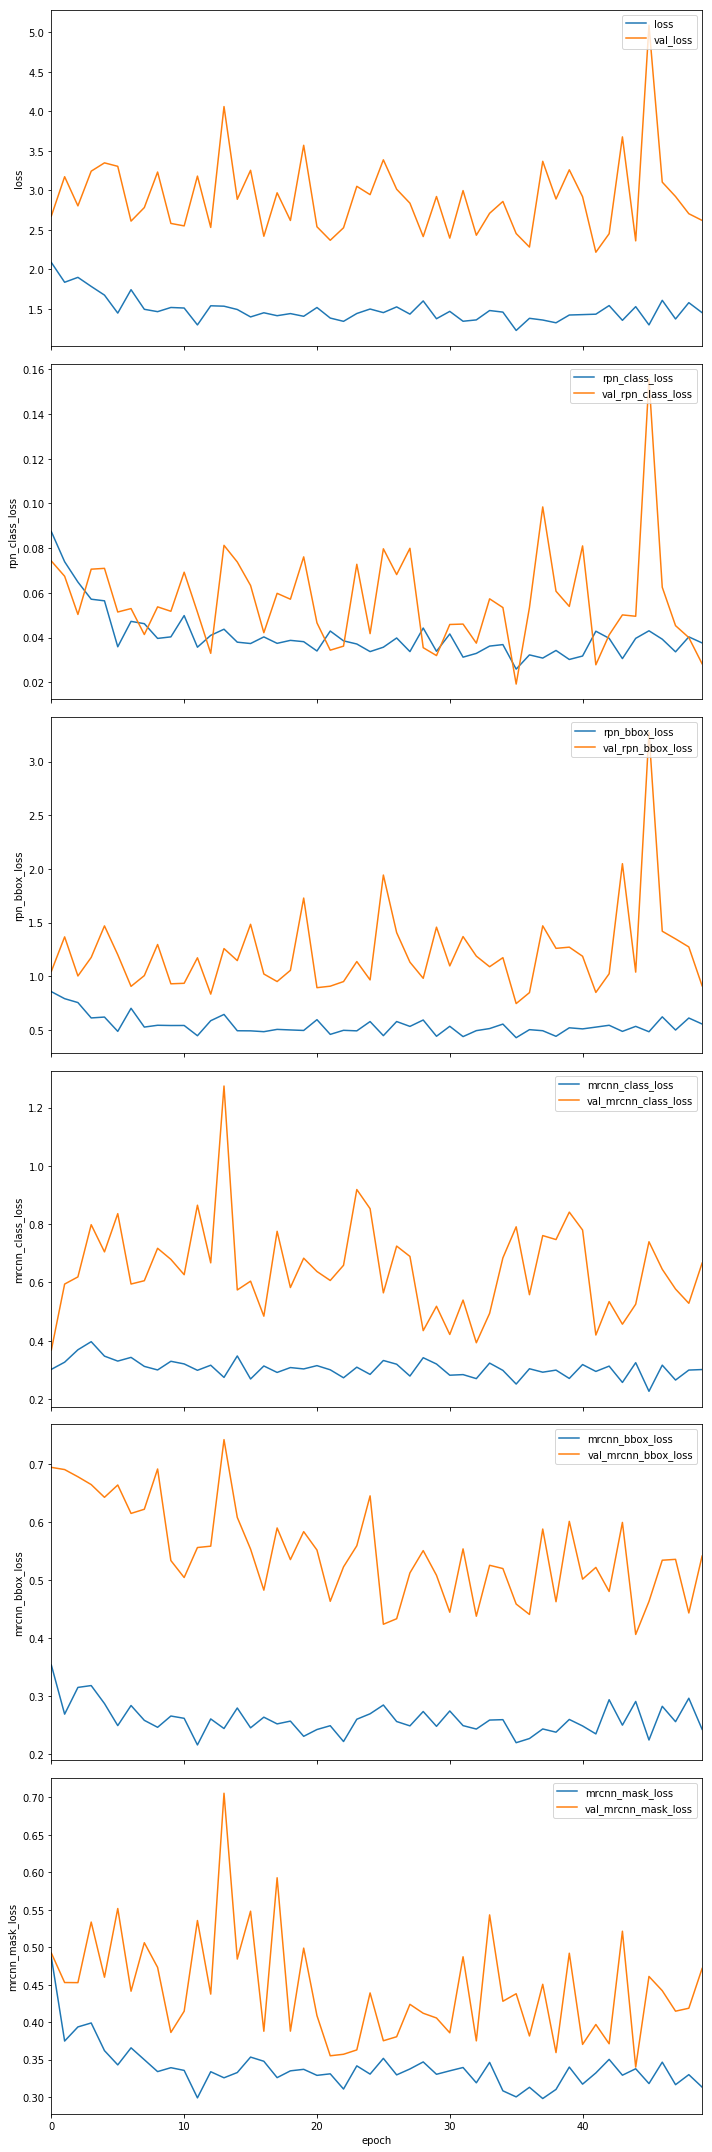

In [150]:
histplot(history_heads)

In [151]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 50. LR=0.0001

Checkpoint Path: /gpfs01/home/ppzsb1/astobjdet/Mask_RCNN/logs/astroobjects20190412T1223/mask_rcnn_astroobjects_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bran

/gpfs01/home/ppzsb1/.conda/envs/astobjdet/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/gpfs01/home/ppzsb1/.conda/envs/astobjdet/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 51/100
300/300 [==============================] - 132s 442ms/step - loss: 2.1044 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.8487 - mrcnn_class_loss: 0.4349 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.3883 - val_loss: 2.2088 - val_rpn_class_loss: 0.0474 - val_rpn_bbox_loss: 0.8662 - val_mrcnn_class_loss: 0.4017 - val_mrcnn_bbox_loss: 0.4834 - val_mrcnn_mask_loss: 0.4101
Epoch 52/100
300/300 [==============================] - 104s 347ms/step - loss: 1.8919 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.7382 - mrcnn_class_loss: 0.4305 - mrcnn_bbox_loss: 0.3391 - mrcnn_mask_loss: 0.3322 - val_loss: 2.4769 - val_rpn_class_loss: 0.0496 - val_rpn_bbox_loss: 1.1824 - val_mrcnn_class_loss: 0.3703 - val_mrcnn_bbox_loss: 0.4310 - val_mrcnn_mask_loss: 0.4436
Epoch 53/100
300/300 [==============================] - 110s 366ms/step - loss: 2.1536 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.9426 - mrcnn_class_loss: 0.4153 - mrcnn_bbox_loss: 0.3907 - mrcnn_mask_loss: 0.3586 - val_loss: 2.1752 - 

300/300 [==============================] - 110s 368ms/step - loss: 1.6401 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.5988 - mrcnn_class_loss: 0.3734 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.3205 - val_loss: 1.8325 - val_rpn_class_loss: 0.0265 - val_rpn_bbox_loss: 0.7201 - val_mrcnn_class_loss: 0.4327 - val_mrcnn_bbox_loss: 0.3380 - val_mrcnn_mask_loss: 0.3150
Epoch 73/100
300/300 [==============================] - 110s 367ms/step - loss: 1.4906 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.3408 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.3125 - val_loss: 1.7421 - val_rpn_class_loss: 0.0340 - val_rpn_bbox_loss: 0.6478 - val_mrcnn_class_loss: 0.4252 - val_mrcnn_bbox_loss: 0.3333 - val_mrcnn_mask_loss: 0.3018
Epoch 74/100
300/300 [==============================] - 110s 368ms/step - loss: 1.6208 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.5473 - mrcnn_class_loss: 0.3436 - mrcnn_bbox_loss: 0.3389 - mrcnn_mask_loss: 0.3538 - val_loss: 2.1236 - val_rpn_class

300/300 [==============================] - 111s 369ms/step - loss: 1.5836 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5585 - mrcnn_class_loss: 0.3175 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.3415 - val_loss: 1.8571 - val_rpn_class_loss: 0.0327 - val_rpn_bbox_loss: 0.6926 - val_mrcnn_class_loss: 0.3763 - val_mrcnn_bbox_loss: 0.3791 - val_mrcnn_mask_loss: 0.3764
Epoch 94/100
300/300 [==============================] - 111s 372ms/step - loss: 1.4717 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.5309 - mrcnn_class_loss: 0.2875 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.3253 - val_loss: 2.6402 - val_rpn_class_loss: 0.0341 - val_rpn_bbox_loss: 1.3125 - val_mrcnn_class_loss: 0.3523 - val_mrcnn_bbox_loss: 0.5010 - val_mrcnn_mask_loss: 0.4403
Epoch 95/100
300/300 [==============================] - 110s 367ms/step - loss: 1.5473 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.5478 - mrcnn_class_loss: 0.3528 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.3136 - val_loss: 1.8573 - val_rpn_class

In [152]:
history_fine = get_history(model)

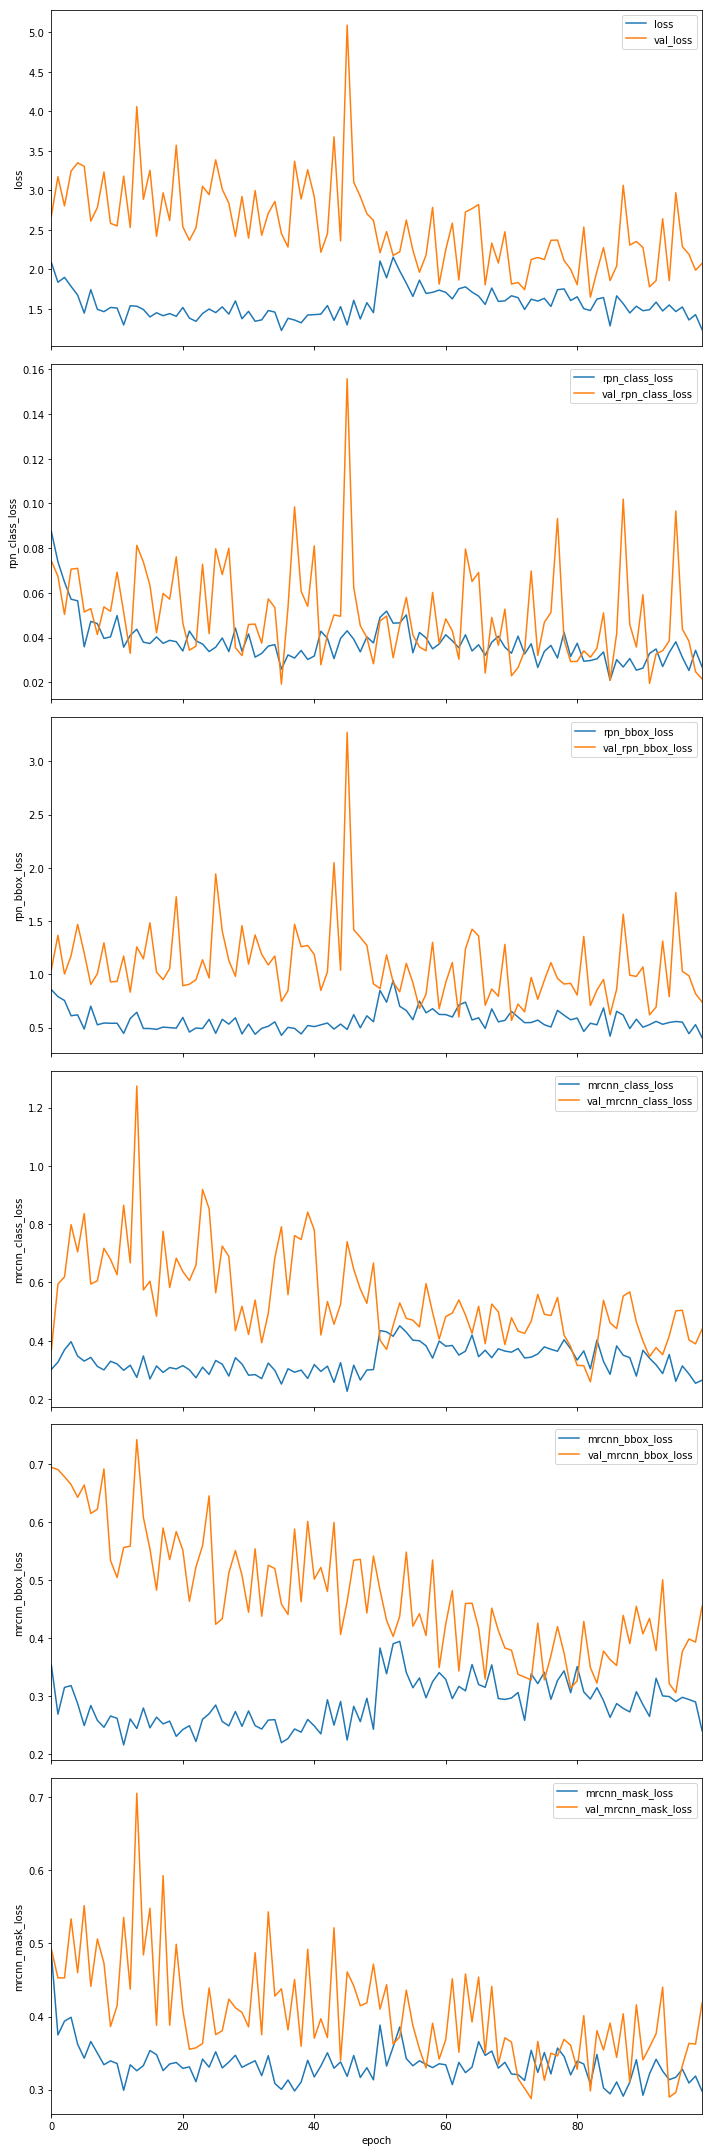

In [153]:
histplot(history_fine)

In [154]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [155]:
class InferenceConfig(AstroObjectsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /gpfs01/home/ppzsb1/astobjdet/Mask_RCNN/logs/astroobjects20190412T1223/mask_rcnn_astroobjects_0100.h5
Re-starting from epoch 100


### Original image

In [272]:
image_id

446

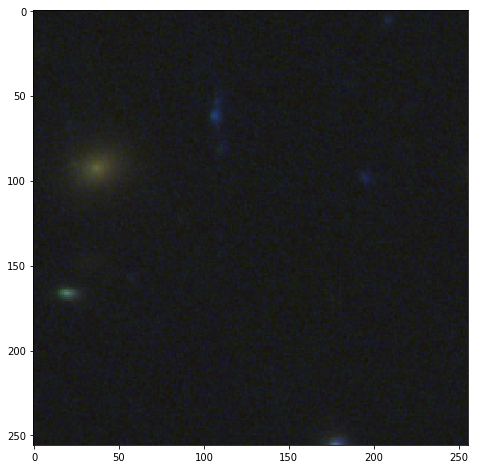

In [310]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# some interesting images:
#image_id = 956
#image_id = 608
#image_id = 741
#image_id = 1729
#image_id = 453
#image_id = 446

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

plt.figure(figsize=(8, 8))
plt.imshow(original_image);

### Image with original segmentation

original_image           shape: (256, 256, 3)         min:    0.00000  max:  147.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1338.00000  int64
gt_class_id              shape: (9,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (9, 4)                min:    4.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 9)         min:    0.00000  max:    1.00000  bool


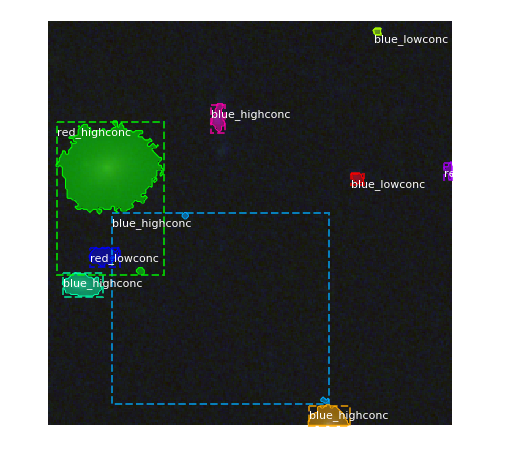

In [311]:
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

### Image with Mask-RCNN objects

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  147.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -106.80000  max:   43.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


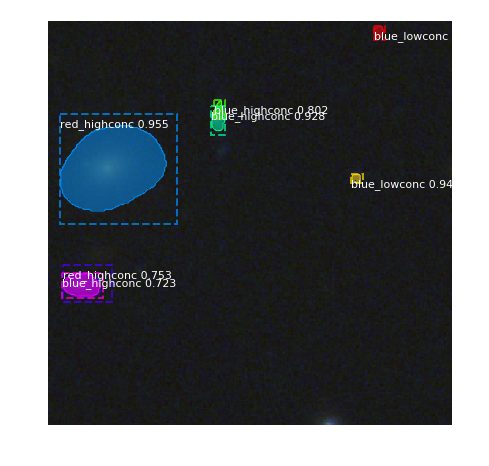

In [312]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))

## Evaluation

In [313]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 100 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
#image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    if not np.isnan(AP):
        APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.27340170203031056
